The tile coordinates are (193097, 111760)


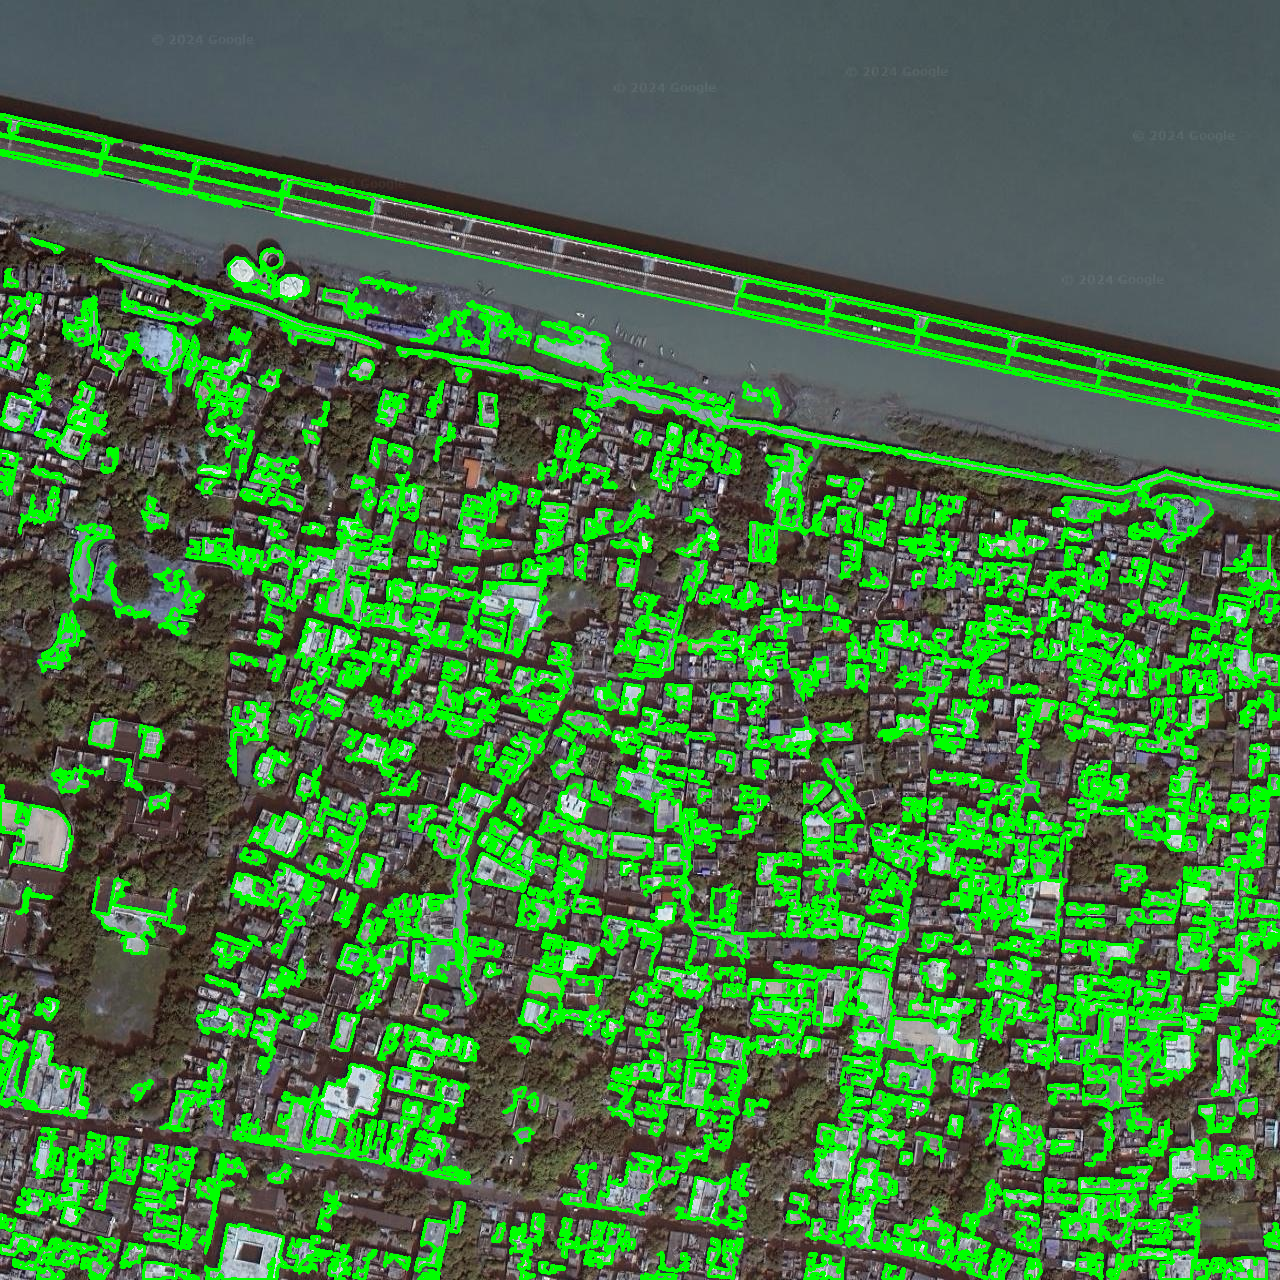

Number of rooftops: 548
The map with rooftop contours has been successfully created


In [4]:
#Canny edge detection
from PIL import Image
import os
import math
import urllib.request
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

class GoogleMapDownloader:
    """
    A class that generates high-resolution Google Maps images given
    a latitude, longitude, and zoom level.
    """

    def __init__(self, lat, lng, zoom=12):
        """
        GoogleMapDownloader Constructor
        Args:
            lat:  The latitude of the location required
            lng:  The longitude of the location required
            zoom: The zoom level of the location required, ranges from 0 - 23
                  defaults to 12
        """
        self._lat = lat
        self._lng = lng
        self._zoom = zoom

    def getXY(self):
        """
        Generates an X,Y tile coordinate based on the latitude, longitude,
        and zoom level.
        Returns: An X,Y tile coordinate
        """

        tile_size = 256

        # Use a left shift to get the power of 2
        # i.e. a zoom level of 2 will have 2^2 = 4 tiles
        numTiles = 1 << self._zoom

        # Find the x_point given the longitude
        point_x = (tile_size / 2 + self._lng * tile_size / 360.0) * numTiles // tile_size

        # Convert the latitude to radians and take the sine
        sin_y = math.sin(self._lat * (math.pi / 180.0))

        # Calculate the y coordinate
        point_y = ((tile_size / 2) + 0.5 * math.log((1 + sin_y) / (1 - sin_y)) *
                   -(tile_size / (2 * math.pi))) * numTiles // tile_size

        return int(point_x), int(point_y)

    def generateImage(self, **kwargs):
        """
        Generates an image by stitching a number of Google Map tiles together.

        Args:
            start_x:     The top-left x-tile coordinate
            start_y:     The top-left y-tile coordinate
            tile_width:  The number of tiles wide the image should be -
                         defaults to 5
            tile_height: The number of tiles high the image should be -
                         defaults to 5
        Returns:
            A high-resolution Google Map image.
        """

        start_x = kwargs.get('start_x', None)
        start_y = kwargs.get('start_y', None)
        tile_width = kwargs.get('tile_width', 5)
        tile_height = kwargs.get('tile_height', 5)

        # Check that we have x and y tile coordinates
        if start_x is None or start_y is None:
            start_x, start_y = self.getXY()

        # Determine the size of the image
        width, height = 256 * tile_width, 256 * tile_height

        # Create a new image of the size required
        map_img = Image.new('RGB', (width, height))

        for x in range(0, tile_width):
            for y in range(0, tile_height):
                url = 'https://mt0.google.com/vt/lyrs=s&x=' + str(start_x + x) + '&y=' + str(start_y + y) + '&z=' + str(self._zoom)

                current_tile = str(x) + '-' + str(y)
                urllib.request.urlretrieve(url, current_tile)

                im = Image.open(current_tile)
                map_img.paste(im, (x * 256, y * 256))

                os.remove(current_tile)

        return map_img

    def countRooftops(self, image):
        # Convert the image to a NumPy array
        img_array = np.array(image)

        # Convert the image to HSV color space
        hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)

        # Define the lower and upper bounds for the rooftop color
        lower_bound = np.array([0, 0, 120], dtype=np.uint8)
        upper_bound = np.array([179, 50, 255], dtype=np.uint8)

        # Create a mask based on the color range
        mask = cv2.inRange(hsv, lower_bound, upper_bound)

        # Apply the mask to the image
        masked_image = cv2.bitwise_and(img_array, img_array, mask=mask)

        # Convert the masked image to grayscale
        gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)

        # Apply binary thresholding
        _, thresholded = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        # Find contours in the binary image
        contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area
        min_contour_area = 85  # Adjust this threshold based on the image characteristics
        filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_contour_area]

        # Create a mask for drawing contours
        contour_mask = np.zeros_like(img_array)

        # Draw the contours on the mask
        cv2.drawContours(contour_mask, filtered_contours, -1, (255, 255, 255), thickness=cv2.FILLED)

        # Convert the mask to grayscale
        contour_mask_gray = cv2.cvtColor(contour_mask, cv2.COLOR_RGB2GRAY)

        # Find contours in the binary mask
        contours, _ = cv2.findContours(contour_mask_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw the contours on the original image
        cv2.drawContours(img_array, contours, -1, (0, 255, 0), 2)

        # Display the image with rooftop contours
        cv2_imshow(img_array)

        # Return the number of rooftops
        return len(contours)

def main():
    # Create a new instance of GoogleMapDownloader
    gmd = GoogleMapDownloader(25.620633, 85.179057, 18)

    print("The tile coordinates are {}".format(gmd.getXY()))

    try:
        # Get the high-resolution image
        img = gmd.generateImage()

        # Count rooftops in the image using color-based filtering and contour area
        rooftops_count = gmd.countRooftops(img)
        print(f'Number of rooftops: {rooftops_count}')
    except IOError:
        print("Could not generate the image - try adjusting the zoom level and checking your coordinates")
    else:
        # Save the image to disk
        img.save("high_resolution_image_with_rooftops.png")
        print("The map with rooftop contours has been successfully created")

if __name__ == '__main__':
    main()

The tile coordinates are (193097, 111760)


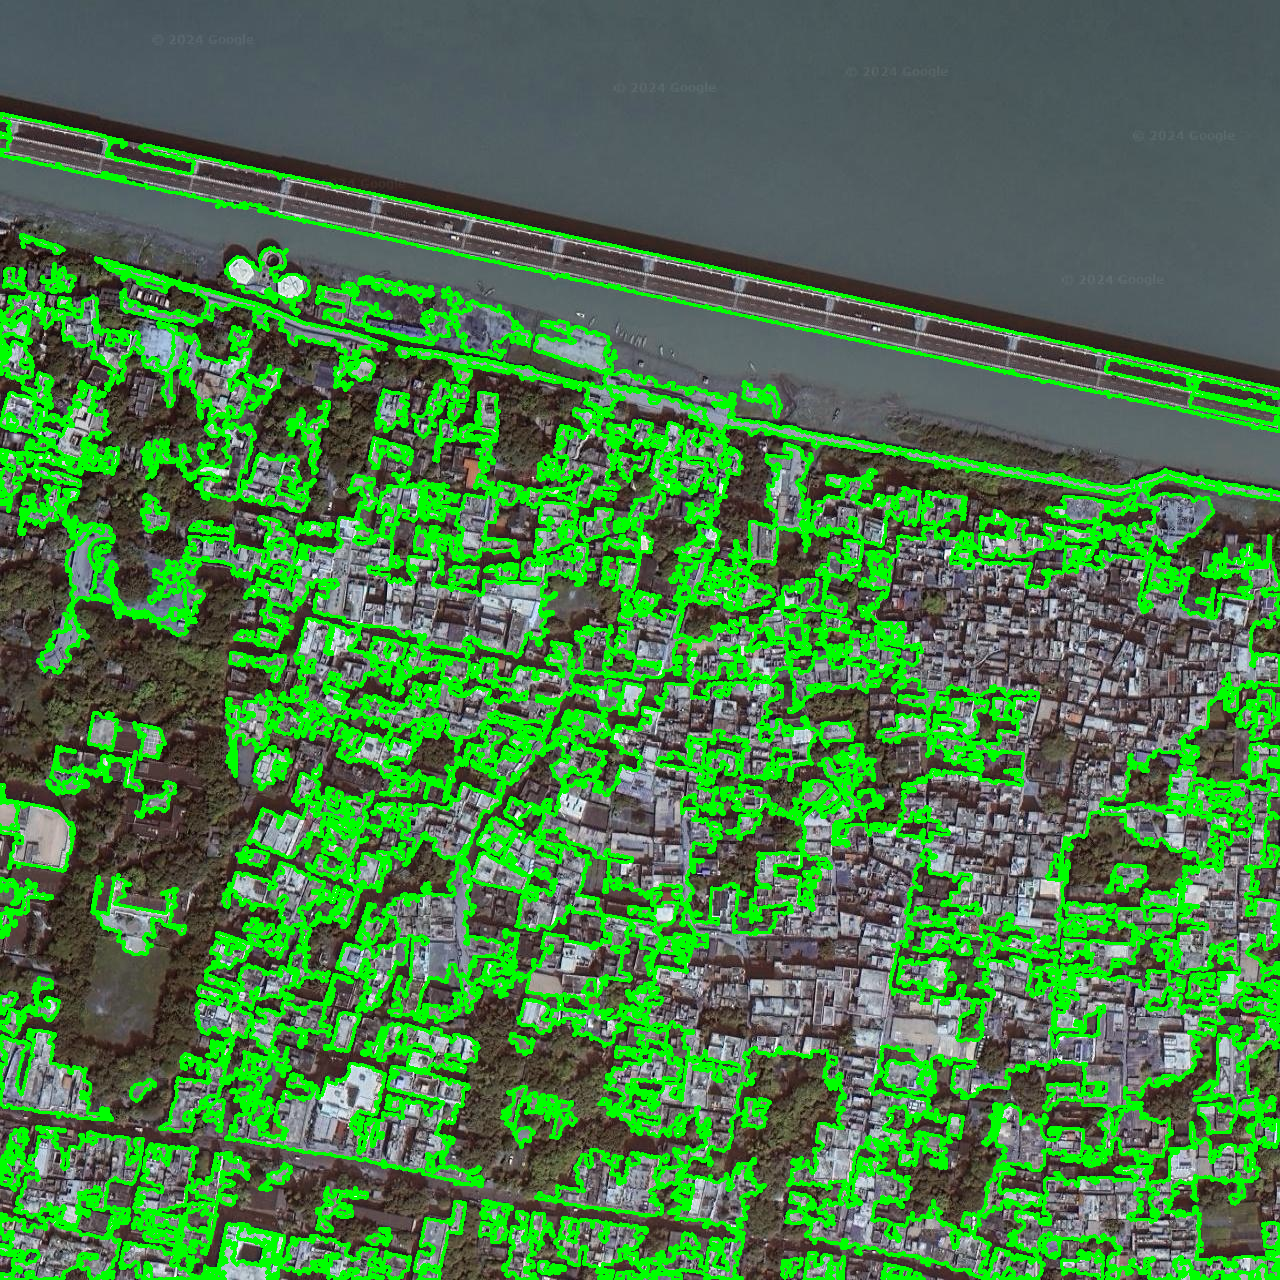

Number of rooftops: 153
The map with rooftop contours has been successfully created


In [4]:
#Laplacian edge detection - can't differentiate the houses from each other

from PIL import Image
import os
import math
import urllib.request
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

class GoogleMapDownloader:
    """
    A class that generates high-resolution Google Maps images given
    a latitude, longitude, and zoom level.
    """

    def __init__(self, lat, lng, zoom=12):
        """
        GoogleMapDownloader Constructor
        Args:
            lat:  The latitude of the location required
            lng:  The longitude of the location required
            zoom: The zoom level of the location required, ranges from 0 - 23
                  defaults to 12
        """
        self._lat = lat
        self._lng = lng
        self._zoom = zoom

    def getXY(self):
        """
        Generates an X,Y tile coordinate based on the latitude, longitude,
        and zoom level.
        Returns: An X,Y tile coordinate
        """

        tile_size = 256

        # Use a left shift to get the power of 2
        # i.e. a zoom level of 2 will have 2^2 = 4 tiles
        numTiles = 1 << self._zoom

        # Find the x_point given the longitude
        point_x = (tile_size / 2 + self._lng * tile_size / 360.0) * numTiles // tile_size

        # Convert the latitude to radians and take the sine
        sin_y = math.sin(self._lat * (math.pi / 180.0))

        # Calculate the y coordinate
        point_y = ((tile_size / 2) + 0.5 * math.log((1 + sin_y) / (1 - sin_y)) *
                   -(tile_size / (2 * math.pi))) * numTiles // tile_size

        return int(point_x), int(point_y)

    def generateImage(self, **kwargs):
        """
        Generates an image by stitching a number of Google Map tiles together.

        Args:
            start_x:     The top-left x-tile coordinate
            start_y:     The top-left y-tile coordinate
            tile_width:  The number of tiles wide the image should be -
                         defaults to 5
            tile_height: The number of tiles high the image should be -
                         defaults to 5
        Returns:
            A high-resolution Google Map image.
        """

        start_x = kwargs.get('start_x', None)
        start_y = kwargs.get('start_y', None)
        tile_width = kwargs.get('tile_width', 5)
        tile_height = kwargs.get('tile_height', 5)

        # Check that we have x and y tile coordinates
        if start_x is None or start_y is None:
            start_x, start_y = self.getXY()

        # Determine the size of the image
        width, height = 256 * tile_width, 256 * tile_height

        # Create a new image of the size required
        map_img = Image.new('RGB', (width, height))

        for x in range(0, tile_width):
            for y in range(0, tile_height):
                url = 'https://mt0.google.com/vt/lyrs=s&x=' + str(start_x + x) + '&y=' + str(start_y + y) + '&z=' + str(self._zoom)

                current_tile = str(x) + '-' + str(y)
                urllib.request.urlretrieve(url, current_tile)

                im = Image.open(current_tile)
                map_img.paste(im, (x * 256, y * 256))

                os.remove(current_tile)

        return map_img

    def countRooftops(self, image):
        # Convert the image to a NumPy array
        img_array = np.array(image)

        # Convert the image to HSV color space
        hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)

        # Define the lower and upper bounds for the rooftop color
        lower_bound = np.array([0, 0, 120], dtype=np.uint8)
        upper_bound = np.array([179, 50, 255], dtype=np.uint8)

        # Create a mask based on the color range
        mask = cv2.inRange(hsv, lower_bound, upper_bound)

        # Apply the mask to the image
        masked_image = cv2.bitwise_and(img_array, img_array, mask=mask)

        # Convert the masked image to grayscale
        gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)

        # Apply Laplacian edge detection
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)

        # Threshold the Laplacian image
        _, thresholded = cv2.threshold(np.abs(laplacian).astype(np.uint8), 30, 255, cv2.THRESH_BINARY)

        # Find contours in the binary image
        contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area
        min_contour_area = 85  # Adjust this threshold based on the image characteristics
        filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_contour_area]

        # Create a mask for drawing contours
        contour_mask = np.zeros_like(img_array)

        # Draw the contours on the mask
        cv2.drawContours(contour_mask, filtered_contours, -1, (255, 255, 255), thickness=cv2.FILLED)

        # Convert the mask to grayscale
        contour_mask_gray = cv2.cvtColor(contour_mask, cv2.COLOR_RGB2GRAY)

        # Find contours in the binary mask
        contours, _ = cv2.findContours(contour_mask_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw the contours on the original image
        cv2.drawContours(img_array, contours, -1, (0, 255, 0), 2)

        # Display the image with rooftop contours
        cv2_imshow(img_array)

        # Return the number of rooftops
        return len(contours)

def main():
    # Create a new instance of GoogleMapDownloader
    gmd = GoogleMapDownloader(25.620633, 85.179057, 18)

    print("The tile coordinates are {}".format(gmd.getXY()))

    try:
        # Get the high-resolution image
        img = gmd.generateImage()

        # Count rooftops in the image using color-based filtering and contour area
        rooftops_count = gmd.countRooftops(img)
        print(f'Number of rooftops: {rooftops_count}')
    except IOError:
        print("Could not generate the image - try adjusting the zoom level and checking your coordinates")
    else:
        # Save the image to disk
        img.save("high_resolution_image_with_rooftops.png")
        print("The map with rooftop contours has been successfully created")

if __name__ == '__main__':
    main()


The tile coordinates are (193097, 111760)


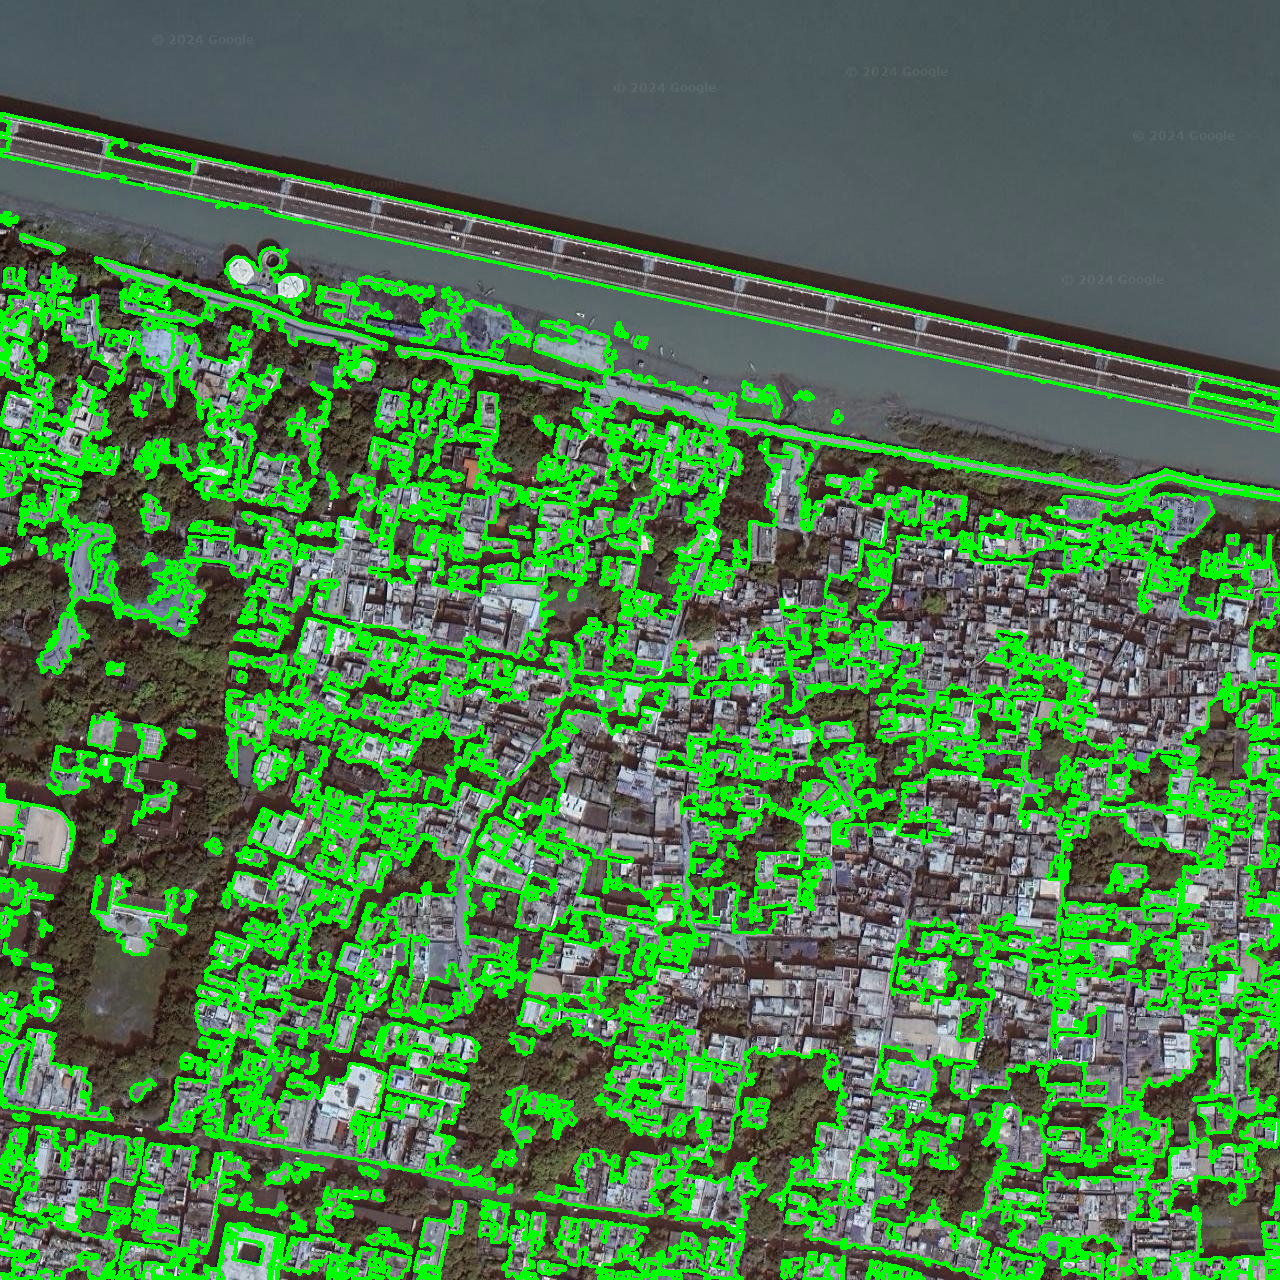

Number of rooftops: 264
The map with rooftop contours has been successfully created


In [6]:

#Gradient edge detection(Sobel edge detection)
from PIL import Image
import os
import math
import urllib.request
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

class GoogleMapDownloader:
    """
    A class that generates high-resolution Google Maps images given
    a latitude, longitude, and zoom level.
    """

    def __init__(self, lat, lng, zoom=12):
        """
        GoogleMapDownloader Constructor
        Args:
            lat:  The latitude of the location required
            lng:  The longitude of the location required
            zoom: The zoom level of the location required, ranges from 0 - 23
                  defaults to 12
        """
        self._lat = lat
        self._lng = lng
        self._zoom = zoom

    def getXY(self):
        """
        Generates an X,Y tile coordinate based on the latitude, longitude,
        and zoom level.
        Returns: An X,Y tile coordinate
        """

        tile_size = 256

        # Use a left shift to get the power of 2
        # i.e. a zoom level of 2 will have 2^2 = 4 tiles
        numTiles = 1 << self._zoom

        # Find the x_point given the longitude
        point_x = (tile_size / 2 + self._lng * tile_size / 360.0) * numTiles // tile_size

        # Convert the latitude to radians and take the sine
        sin_y = math.sin(self._lat * (math.pi / 180.0))

        # Calculate the y coordinate
        point_y = ((tile_size / 2) + 0.5 * math.log((1 + sin_y) / (1 - sin_y)) *
                   -(tile_size / (2 * math.pi))) * numTiles // tile_size

        return int(point_x), int(point_y)

    def generateImage(self, **kwargs):
        """
        Generates an image by stitching a number of Google Map tiles together.

        Args:
            start_x:     The top-left x-tile coordinate
            start_y:     The top-left y-tile coordinate
            tile_width:  The number of tiles wide the image should be -
                         defaults to 5
            tile_height: The number of tiles high the image should be -
                         defaults to 5
        Returns:
            A high-resolution Google Map image.
        """

        start_x = kwargs.get('start_x', None)
        start_y = kwargs.get('start_y', None)
        tile_width = kwargs.get('tile_width', 5)
        tile_height = kwargs.get('tile_height', 5)

        # Check that we have x and y tile coordinates
        if start_x is None or start_y is None:
            start_x, start_y = self.getXY()

        # Determine the size of the image
        width, height = 256 * tile_width, 256 * tile_height

        # Create a new image of the size required
        map_img = Image.new('RGB', (width, height))

        for x in range(0, tile_width):
            for y in range(0, tile_height):
                url = 'https://mt0.google.com/vt/lyrs=s&x=' + str(start_x + x) + '&y=' + str(start_y + y) + '&z=' + str(self._zoom)

                current_tile = str(x) + '-' + str(y)
                urllib.request.urlretrieve(url, current_tile)

                im = Image.open(current_tile)
                map_img.paste(im, (x * 256, y * 256))

                os.remove(current_tile)

        return map_img

    def countRooftops(self, image):
        # Convert the image to a NumPy array
        img_array = np.array(image)

        # Convert the image to HSV color space
        hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)

        # Define the lower and upper bounds for the rooftop color
        lower_bound = np.array([0, 0, 120], dtype=np.uint8)
        upper_bound = np.array([179, 50, 255], dtype=np.uint8)

        # Create a mask based on the color range
        mask = cv2.inRange(hsv, lower_bound, upper_bound)

        # Apply the mask to the image
        masked_image = cv2.bitwise_and(img_array, img_array, mask=mask)

        # Convert the masked image to grayscale
        gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)

        # Apply Sobel edge detection
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        edges = np.sqrt(sobel_x**2 + sobel_y**2)

        # Normalize the edges to the range [0, 255]
        edges = np.uint8(255 * edges / np.max(edges))

        # Apply binary thresholding
        _, thresholded = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)

        # Find contours in the binary image
        contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area
        min_contour_area = 85  # Adjust this threshold based on the image characteristics
        filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_contour_area]

        # Create a mask for drawing contours
        contour_mask = np.zeros_like(img_array)

        # Draw the contours on the mask
        cv2.drawContours(contour_mask, filtered_contours, -1, (255, 255, 255), thickness=cv2.FILLED)

        # Convert the mask to grayscale
        contour_mask_gray = cv2.cvtColor(contour_mask, cv2.COLOR_RGB2GRAY)

        # Find contours in the binary mask
        contours, _ = cv2.findContours(contour_mask_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw the contours on the original image
        cv2.drawContours(img_array, contours, -1, (0, 255, 0), 2)

        # Display the image with rooftop contours
        cv2_imshow(img_array)

        # Return the number of rooftops
        return len(contours)

def main():
    # Create a new instance of GoogleMapDownloader
    gmd = GoogleMapDownloader(25.620633, 85.179057, 18)

    print("The tile coordinates are {}".format(gmd.getXY()))

    try:
        # Get the high-resolution image
        img = gmd.generateImage()

        # Count rooftops in the image using color-based filtering and Sobel edge detection
        rooftops_count = gmd.countRooftops(img)
        print(f'Number of rooftops: {rooftops_count}')
    except IOError:
        print("Could not generate the image - try adjusting the zoom level and checking your coordinates")
    else:
        # Save the image to disk
        img.save("high_resolution_image_with_rooftops.png")
        print("The map with rooftop contours has been successfully created")

if __name__ == '__main__':
    main()
